# NASA CMAPSS FD001 — SCARF + RUL (Temiz Notebook)

Bu notebook, proje boyunca yaptığımız denemeleri **tek bir net akış** halinde toplar.

**Hedef:**
- FD001 verisinde, **SCARF self-supervised pretraining** ile temsil öğren
- Sonra **kademeli fine-tune** (önce head, sonra encoder küçük LR) ile **RUL regresyonu** yap

**Önemli:**
- Split **unit_nr (motor) bazında** yapılır.
- Ölçekleyici (MinMaxScaler) **yalnızca train unit'lerinde fit** edilir (leakage engellenir).
- Literatürde yaygın protokol için **RUL cap = 125** kullanılır.

Bu notebook, mümkün olduğunca kısa tutmak için fonksiyonları doğrudan [experiment_window_size.py](experiment_window_size.py) içinden import eder.

In [31]:
# 1) Ortam / Importlar

import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch

# Proje içi yardımcılar (temiz notebook = az tekrar)
from experiment_window_size import (
    ExperimentConfig,
    set_seed,
    load_cmapss_train,
    prepare_dataset_for_window,
    pretrain_scarf,
    finetune_regressor,
)

print("cwd:", os.getcwd())
print("python/torch:", torch.__version__)
print("cuda:", torch.cuda.is_available())

cwd: /Users/kisli/Desktop/rul_scarf 2
python/torch: 2.9.1
cuda: False


In [32]:
# 2) Konfigürasyon (BEST)

DATA_PATH = Path("train_FD001.txt")
OUTPUT_DIR = Path("artifacts_best_notebook")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

cfg = ExperimentConfig(
    data_path=str(DATA_PATH),
    seed=42,
    test_size=0.2,
    window_size=50,
    pretrain_epochs=5,
    ft_head_epochs=5,
    ft_full_epochs=10,
    corruption_rate=0.6,
    temperature=0.1,
    lr_head=1e-3,
    lr_encoder=1e-4,
    rul_cap=125,
    loss="mse",
    out_dir=str(OUTPUT_DIR),
)

set_seed(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("DATA_PATH exists?:", DATA_PATH.exists())
print("OUTPUT_DIR:", OUTPUT_DIR)

device: cpu
DATA_PATH exists?: True
OUTPUT_DIR: artifacts_best_notebook


In [33]:
# 3) Veri yükleme (ham -> DataFrame)

df_raw = load_cmapss_train(cfg.data_path)

# Basit doğrulamalar
assert {"unit_nr", "time_cycles"}.issubset(df_raw.columns)
assert df_raw.shape[1] == 26  # FD001 train: 2 index + 3 setting + 21 sensor

print("df_raw shape:", df_raw.shape)
df_raw.head()

df_raw shape: (20631, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [34]:
# 4) Hızlı veri inceleme

print("n_units:", df_raw["unit_nr"].nunique())
print("time_cycles min/max:", df_raw["time_cycles"].min(), df_raw["time_cycles"].max())

# Eksik değer var mı?
na_count = df_raw.isna().sum().sum()
print("total NA:", int(na_count))

# Her unit için kaç cycle var?
unit_lengths = df_raw.groupby("unit_nr")["time_cycles"].max()
unit_lengths.describe()

n_units: 100
time_cycles min/max: 1 362
total NA: 0


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time_cycles, dtype: float64

## 5) Ön işleme + Window oluşturma (Leakage yok)

Bu adım [experiment_window_size.py](experiment_window_size.py) içindeki `prepare_dataset_for_window()` ile yapılır:
- unit bazlı split
- constant kolonları **train subset** üstünden bulup drop
- scaler'ı **train** üstünde fit edip val'e uygula
- `window_size=50` ile flatten window vektörleri üret
- `RUL = max_cycle(unit) - end_cycle(window)` ve `rul_cap=125` uygula

Çıktı: `X_tr, y_tr, X_va, y_va`

In [35]:
ds = prepare_dataset_for_window(df_raw, window_size=cfg.window_size, cfg=cfg)

X_tr = ds["X_tr"]
y_tr = ds["y_tr"]
X_va = ds["X_va"]
y_va = ds["y_va"]
input_dim = int(ds["input_dim"][0])

print("X_tr:", X_tr.shape, "y_tr:", y_tr.shape)
print("X_va:", X_va.shape, "y_va:", y_va.shape)
print("input_dim:", input_dim)
print("y_tr range:", float(y_tr.min()), float(y_tr.max()))
print("y_va range:", float(y_va.min()), float(y_va.max()))

X_tr: (12641, 1000) y_tr: (12641,)
X_va: (3090, 1000) y_va: (3090,)
input_dim: 1000
y_tr range: 0.0 125.0
y_va range: 0.0 125.0


## 6) SCARF Pretraining (Self-Supervised)

Bu aşamada etiket kullanmıyoruz. Model, `x` ile onun SCARF corruption ile bozulmuş kopyası `x̃` arasında kontrastif öğrenme yapar.

Best ayarlar:
- `corruption_rate=0.6`
- `temperature=0.1`
- `pretrain_epochs=5` (hızlı ve yeterli bir baseline)

In [36]:
encoder = pretrain_scarf(X_tr, input_dim=input_dim, cfg=cfg, device=device)

[pretrain] epoch 01/5 loss=5.3535
[pretrain] epoch 02/5 loss=5.2333
[pretrain] epoch 03/5 loss=5.2299
[pretrain] epoch 04/5 loss=5.2212
[pretrain] epoch 05/5 loss=5.2174


## 7) Kademeli Fine-Tune (RUL Regresyonu)

İki aşama:
1. **Head-only:** Encoder frozen, sadece küçük regression head öğrenir.
2. **Full fine-tune:** Encoder açılır ama encoder LR daha küçük tutulur (`lr_encoder=1e-4`).

Bu strateji, hem stabilite hem de temsilin bozulmaması için iyi çalışır.

In [37]:
best_val_rmse = finetune_regressor(
    encoder,
    X_tr=X_tr,
    y_tr=y_tr,
    X_va=X_va,
    y_va=y_va,
    cfg=cfg,
    device=device,
)

print("best_val_rmse (during training):", float(best_val_rmse))
print("artifacts saved under:", cfg.out_dir)

[ft-head] epoch 01/5 train_rmse=85.80 val_rmse=81.38 best=81.38
[ft-head] epoch 02/5 train_rmse=84.49 val_rmse=79.38 best=79.38
[ft-head] epoch 03/5 train_rmse=81.75 val_rmse=76.03 best=76.03
[ft-head] epoch 04/5 train_rmse=77.74 val_rmse=71.67 best=71.67
[ft-head] epoch 05/5 train_rmse=72.80 val_rmse=66.70 best=66.70
[ft-full] epoch 01/10 train_rmse=51.37 val_rmse=30.03 best=30.03
[ft-full] epoch 02/10 train_rmse=29.88 val_rmse=20.62 best=20.62
[ft-full] epoch 03/10 train_rmse=25.45 val_rmse=19.48 best=19.48
[ft-full] epoch 04/10 train_rmse=24.07 val_rmse=18.69 best=18.69
[ft-full] epoch 05/10 train_rmse=23.33 val_rmse=18.43 best=18.43
[ft-full] epoch 06/10 train_rmse=22.28 val_rmse=17.42 best=17.42
[ft-full] epoch 07/10 train_rmse=21.60 val_rmse=17.05 best=17.05
[ft-full] epoch 08/10 train_rmse=20.82 val_rmse=17.14 best=17.05
[ft-full] epoch 09/10 train_rmse=20.22 val_rmse=16.49 best=16.49
[ft-full] epoch 10/10 train_rmse=19.50 val_rmse=15.15 best=15.15
best_val_rmse (during training

VAL RMSE: 15.703304290771484
VAL MAE: 12.645143508911133
run_dir: artifacts_best_notebook
saved: artifacts_best_notebook/val_predictions.csv
saved: artifacts_best_notebook/metrics.json
saved: artifacts_best_notebook/val_true_vs_pred.png


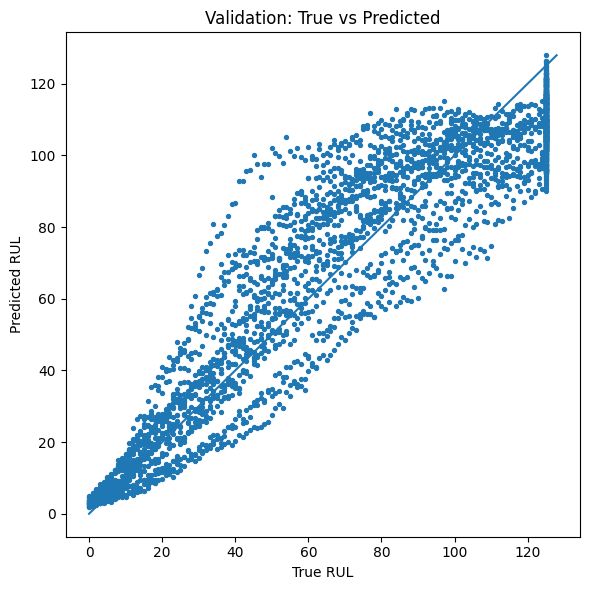

In [38]:
# 8) Hızlı değerlendirme (val RMSE/MAE + scatter + dosyaya kaydetme)

import json

import matplotlib.pyplot as plt

from experiment_window_size import MLPEncoder, RULRegressor


def resolve_run_dir(out_dir: Path) -> Path:
    """Eğitim çıktılarının kaydedildiği klasörü bulur.

    Notebook akışında bazen checkpoint'ler doğrudan `out_dir/` altına yazılır;
    bazen de `out_dir/ws.../` gibi alt klasör açılır. Bu helper her iki durumu da destekler.
    """
    out_dir = Path(out_dir)
    direct_ok = (out_dir / "scarf_pretrained.pt").exists() and (out_dir / "rul_regressor.pt").exists()
    if direct_ok:
        return out_dir

    candidates = [p for p in out_dir.glob("*") if p.is_dir()]
    preferred = [p for p in candidates if p.name.startswith(("ws", "run"))]
    if preferred:
        candidates = preferred

    if not candidates:
        raise FileNotFoundError(f"No run dir or checkpoints found under: {out_dir}")

    # En güncel klasörü seç
    return max(candidates, key=lambda p: p.stat().st_mtime)


run_dir = resolve_run_dir(Path(cfg.out_dir))
scarf_path = run_dir / "scarf_pretrained.pt"
reg_path = run_dir / "rul_regressor.pt"
assert scarf_path.exists(), f"Missing: {scarf_path}"
assert reg_path.exists(), f"Missing: {reg_path}"

encoder_eval = MLPEncoder(
    input_dim=input_dim,
    hidden_dim=cfg.hidden_dim,
    emb_dim=cfg.emb_dim,
    proj_dim=cfg.proj_dim,
    dropout=cfg.dropout,
).to(device)
encoder_eval.load_state_dict(torch.load(scarf_path, map_location=device))

reg_model = RULRegressor(encoder_eval, emb_dim=cfg.emb_dim).to(device)
reg_model.load_state_dict(torch.load(reg_path, map_location=device))
reg_model.eval()


@torch.no_grad()
def predict_np(X: np.ndarray, batch_size: int = 512) -> np.ndarray:
    preds = []
    for i in range(0, X.shape[0], batch_size):
        xb = torch.tensor(X[i : i + batch_size], dtype=torch.float32, device=device)
        preds.append(reg_model(xb).detach().cpu().numpy())
    return np.concatenate(preds, axis=0)


yhat_va = predict_np(X_va).reshape(-1)
y_va_1d = y_va.reshape(-1)

rmse = float(np.sqrt(np.mean((y_va_1d - yhat_va) ** 2)))
mae = float(np.mean(np.abs(y_va_1d - yhat_va)))
print("VAL RMSE:", rmse)
print("VAL MAE:", mae)
print("run_dir:", run_dir)

# ---- Dosyaya kaydet ----
pred_csv = run_dir / "val_predictions.csv"
metrics_json = run_dir / "metrics.json"
plot_png = run_dir / "val_true_vs_pred.png"

pd.DataFrame({"y_true": y_va_1d, "y_pred": yhat_va}).to_csv(pred_csv, index=False)
with open(metrics_json, "w", encoding="utf-8") as f:
    json.dump(
        {
            "val_rmse": rmse,
            "val_mae": mae,
            "run_dir": str(run_dir),
            "window_size": int(cfg.window_size),
            "rul_cap": None if cfg.rul_cap is None else int(cfg.rul_cap),
            "corruption_rate": float(cfg.corruption_rate),
            "temperature": float(cfg.temperature),
        },
        f,
        indent=2,
        ensure_ascii=False,
    )

print("saved:", pred_csv)
print("saved:", metrics_json)

# ---- Grafik ----
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_va_1d, yhat_va, s=8)
lim_min = float(min(y_va_1d.min(), yhat_va.min()))
lim_max = float(max(y_va_1d.max(), yhat_va.max()))
ax.plot([lim_min, lim_max], [lim_min, lim_max])
ax.set_xlabel("True RUL")
ax.set_ylabel("Predicted RUL")
ax.set_title("Validation: True vs Predicted")
fig.tight_layout()
fig.savefig(plot_png, dpi=150)
print("saved:", plot_png)
plt.show()

## Kısa kullanım özeti (bu notebook)

- **Tüm akışı çalıştırma:** Hücreleri yukarıdan aşağı sırayla çalıştır.
- **Model çıktıları:** Eğitim sonunda `OUTPUT_DIR` altında yeni bir klasör oluşur:
  - `artifacts_best_notebook/ws50_pre5_h5_f10_cr0p6_t0p1_lre0p0001_lrh0p001/`
  - İçerik: `scarf_pretrained.pt` ve `rul_regressor.pt`
- **Val metrikleri & grafik:** Son hücre, `VAL RMSE / VAL MAE` yazdırır ve True-vs-Pred scatter gösterir.

İpucu: Aynı ayarları notebook dışında tek komutla çalıştırmak istersen:
- `python experiment_window_size.py --out-dir artifacts_best_run`
- `python evaluate_best.py --best-dir artifacts_best_run/ws50_pre5_h5_f10_cr0p6_t0p1_lre0p0001_lrh0p001 --out-dir evaluation_best_run`
